# Boston Housing Prices Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Boston Housing Prices**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_이 노트북의 자세한 사용 방법은 다음의 [ReadTheDocs 페이지](http://sagemaker.readthedocs.io/en/latest/) 에서 확인하실 수 있습니다._

SageMaker Python SDK 를 사용하여 비교적 간단한 회귀문제인 보스톤 주택 가치를 예측하는 문제입니다. 데이터는 [보스턴 주택 데이터 세트](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) 를 사용합니다.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

데이터를 살펴본 후 다음을 지정해 보도록 합니다.

- 학습 및 모델 데이터에 사용할 S3 버킷과 prefix 입니다. 이 옵션은 노트북 인스턴스, 교육 및 호스팅과 동일한 지역 내에 있어야 합니다.
- 데이터에 대한 교육 및 호스팅 액세스를 제공하는 데 사용되는 IAM 역할 arn입니다. 이러한 항목을 만드는 방법은 설명서를 참조하십시오. 노트북 인스턴스, 교육 및/또는 호스팅에 둘 이상의 역할이 필요한 경우 boto 정규 표현식을 적절한 전체 IAM 역할 arn 문자열로 교체하십시오.


In [1]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os

In [27]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

bucket = 'yudong-data'
prefix = 'sagemaker/boston-xgboost-LL'

## Data

데이터는 sklearn 의 boston 데이터를 사용합니다. 데이터를 로드하고 데이터를 탐색해 보도록 합니다. 

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [3]:
boston.data.shape

(506, 13)

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [6]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [13]:
import sklearn.model_selection

In [14]:
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

In [15]:
X_bos_pd.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [16]:
Y_bos_pd.head()

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [17]:
X_bos_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [18]:
X_bos_pd.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [19]:
Y_bos_pd.describe()

,0
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


이 데이터가 비교적 깨끗한 테이블 형식 데이터이므로 특별한 전처리 작업없이 진행하도록 합니다. 하지만, 데이터셋을 train, test 및 validation 세트로 분할해 보도록 합니다.

In [20]:
# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

SageMaker를 사용하여 training 작업을 구성하면 training 작업을 수행하는 컨테이너가 실행됩니다. 이 컨테이너에는 S3에 저장된 데이터에 대한 액세스 권한이 부여되고 S3로부터 데이터를 가져와 training 에 사용합니다. 하위 셀들은 training 에 사용할 데이터를 S3에 업로드 합니다.

In [25]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [26]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

현재 SageMaker 세션 내에서 실행 중이므로 이 세션을 나타내는 객체를 사용하여 데이터를 'default' S3 버킷에 업로드할 수 있고 사용자 지정 버킷을 사용하여 업로드 할 수 있습니다. 다른 노트북이나 프로젝트에서 업로드된 데이터를 실수로 방해하지 않도록 사용자 지정 버킷 및 prefix (S3 폴더) 를 제공하는 것이 좋습니다.

In [28]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix, bucket=bucket)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix, bucket=bucket)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix, bucket=bucket)

In [29]:
val_location

's3://yudong-data/sagemaker/boston-xgboost-LL/validation.csv'

---
## Train

training 으로 넘어가면 먼저 XGBOOST 알고리즘 컨테이너의 위치를 지정해야 합니다.

In [35]:
import boto3
from sagemaker.inputs import TrainingInput

In [34]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")
display(container)

'306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest'

In [36]:
train_input = TrainingInput(train_location, content_type='text/csv')
val_input = TrainingInput(val_location, content_type='text/csv')
inputs = {'train':train_input, 'validation':val_input}

어떤 인스턴스 타입을 선택할지 등의 변수와 XGBoost 의 하이퍼 파라미터를 정의합니다. 
- `max_depth` 는 알고리즘 내의 각 트리를 얼마나 깊게 만들 수 있는지를 제어합니다. 나무가 깊어지면 더 잘 맞을 수 있지만 계산 비용이 많이 들고 과적합으로 이어질 수 있습니다. 일반적으로 많은 수의 얕은 나무와 더 적은 수의 더 깊은 나무 사이에서 탐색해야하는 모델 성능에는 약간의 절충점이 있습니다.
- `subsample` 은 학습 데이터의 샘플링을 제어합니다. 이 기술은 과적합을 줄이는 데 도움이 될 수 있지만 너무 낮게 설정하면 데이터 모델이 부족할 수도 있습니다.
- `num_round` 는 부스팅 라운드 수를 제어합니다. 이것은 본질적으로 이전 반복의 잔차를 사용하여 학습되는 후속 모형입니다. 다시 말하지만, 라운드가 많으면 트레이닝 데이터에 더 잘 맞을 수 있지만 계산 비용이 많이 들거나 과적합으로 이어질 수 있습니다.
- `eta` 는 부스팅의 각 라운드가 얼마나 공격적인지를 제어합니다. 값이 클수록 보수적 인 Boosting이 발생합니다.
- `gamma` 는 나무가 얼마나 공격적으로 성장하는지 제어합니다. 값이 클수록 더 보수적인 모델이 됩니다.

다음 GitHub 링크에서 XGBoost hyperparmeters 에 대해 좀 더 자세히 알아볼 수 있습니다. [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [38]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=session,
)
xgb.set_hyperparameters(
    max_depth= 5,
    eta= 0.2,
    gamma= 4,
    min_child_weight= 6,
    subsample= 0.8,
    objective="reg:linear",
    early_stopping_rounds= 10,
    num_round= 200

)

xgb.fit({"train": train_input, "validation": val_input})

2021-09-28 00:24:33 Starting - Starting the training job...
2021-09-28 00:24:57 Starting - Launching requested ML instancesProfilerReport-1632788673: InProgress
......
2021-09-28 00:25:57 Starting - Preparing the instances for training.........
2021-09-28 00:27:21 Downloading - Downloading input data
2021-09-28 00:27:21 Training - Downloading the training image..Arguments: train
[2021-09-28:00:27:44:INFO] Running standalone xgboost training.
[2021-09-28:00:27:44:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8387.96mb
[2021-09-28:00:27:44:INFO] Determined delimiter of CSV input is ','
[00:27:44] S3DistributionType set as FullyReplicated
[00:27:44] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-09-28:00:27:44:INFO] Determined delimiter of CSV input is ','
[00:27:44] S3DistributionType set as FullyReplicated
[00:27:44] 112x13 matrix with 1456 entries loaded from /opt/ml/input/d

---
## Host

이제 알고리즘을 학습했으므로 모델을 만들어 호스팅된 엔드포인트에 배포해 보겠습니다.

In [41]:
from sagemaker.serializers import CSVSerializer

In [42]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', serializer=CSVSerializer())

-----!

### Evaluate

이제 호스팅 된 엔드 포인트가 실행되었으므로 http POST 요청만으로 모델에서 실시간 예측을 매우 쉽게 할 수 있습니다.

In [43]:
Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
Y_pred = np.fromstring(Y_pred, sep=',')

In [45]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Median Price vs Predicted Price')

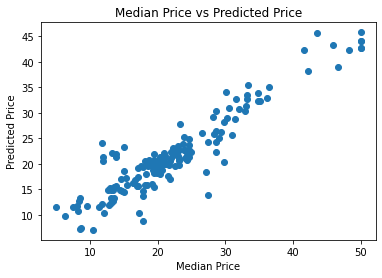

In [46]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")